In [17]:
import pathlib
from torchvision import transforms
from torch.utils.data import random_split, Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import Counter 

## Data loading

In [18]:
class LeafDataset(Dataset):
    
    def __init__(self, data_dir, transform=None):
        self.transform = transform
        self.data_dir = pathlib.Path(data_dir)
        # get the size of the dataset for all possible images jpg, jpeg, png
        self.imgs = list(self.data_dir.glob('*/*'))
        self.imgs = [img for img in self.imgs if "Zone.Identifier" not in img.name]  # Exclude files with "Zone.Identifier" in their name TODELETE
        self.len_data = len(self.imgs)
        self.class_names = sorted([item.name for item in self.data_dir.glob('*')])
        self.class_to_idx = {item: i for i, item in enumerate(self.class_names)}
        self.imgs = [(str(img), self.class_to_idx[img.parent.name]) for img in self.imgs]
        
    def __len__(self):
        return self.len_data
        
    def __getitem__(self, idx):
        
        img_path, label = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

## Images dimension

In [19]:
dataset = LeafDataset('data/')
img_sizes = []
for img, _ in dataset:
    img_sizes.append(img.size)

print('Min image dimension: ', min(img_sizes))
img_sizes = [str(img_size) for img_size in img_sizes]
counts = Counter(img_sizes)
print('Images dimension: ', counts)
del dataset

Min image dimension:  (224, 297)
Images dimension:  Counter({'(256, 256)': 60418, '(800, 600)': 21397, '(300, 300)': 4624, '(1500, 1500)': 2328, '(2048, 1365)': 1729, '(493, 1040)': 958, '(1920, 1080)': 948, '(780, 1040)': 580, '(1080, 1920)': 433, '(1280, 720)': 390, '(1040, 493)': 217, '(585, 1040)': 161, '(1040, 780)': 75, '(758, 1600)': 58, '(588, 1280)': 50, '(899, 1599)': 41, '(750, 1000)': 27, '(622, 1280)': 21, '(960, 1280)': 20, '(900, 1600)': 18, '(1600, 758)': 13, '(1040, 585)': 13, '(499, 332)': 12, '(493, 983)': 12, '(521, 348)': 11, '(493, 986)': 11, '(331, 497)': 10, '(284, 426)': 10, '(381, 571)': 10, '(612, 816)': 10, '(359, 538)': 9, '(426, 284)': 9, '(493, 329)': 9, '(497, 331)': 9, '(538, 359)': 9, '(571, 381)': 9, '(493, 988)': 9, '(225, 299)': 8, '(348, 521)': 8, '(382, 255)': 8, '(317, 238)': 8, '(537, 358)': 8, '(332, 499)': 8, '(493, 984)': 8, '(493, 992)': 8, '(750, 914)': 8, '(493, 990)': 8, '(479, 319)': 7, '(303, 227)': 7, '(319, 479)': 7, '(238, 317)': 7, 

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = LeafDataset('data/', transform=transform)

## Number of element in each class 

In [21]:
print(len(dataset))

95868


## Class names and total number of classes

In [35]:
class_names = dataset.class_names

for i, name in enumerate(class_names):
    print(f"{i}: {name}", end='\n' if (i + 1) % 7 == 0 else '  ')

print('\n Number of classes: ', len(dataset.class_to_idx))

healthy_index = [(i, name) for i, name in enumerate(class_names) if 'healthy' in name]
print('Healthy class:', healthy_index)

0: Apple___alternaria_leaf_spot  1: Apple___black_rot  2: Apple___brown_spot  3: Apple___gray_spot  4: Apple___healthy  5: Apple___rust  6: Apple___scab
7: Bell_pepper___bacterial_spot  8: Bell_pepper___healthy  9: Blueberry___healthy  10: Cassava___bacterial_blight  11: Cassava___brown_streak_disease  12: Cassava___green_mottle  13: Cassava___healthy
14: Cassava___mosaic_disease  15: Cherry___healthy  16: Cherry___powdery_mildew  17: Corn___common_rust  18: Corn___gray_leaf_spot  19: Corn___healthy  20: Corn___northern_leaf_blight
21: Grape___black_measles  22: Grape___black_rot  23: Grape___healthy  24: Grape___isariopsis_leaf_spot  25: Grape_leaf_blight  26: Orange___citrus_greening  27: Peach___bacterial_spot
28: Peach___healthy  29: Potato___bacterial_wilt  30: Potato___early_blight  31: Potato___healthy  32: Potato___late_blight  33: Potato___nematode  34: Potato___pests
35: Potato___phytophthora  36: Potato___virus  37: Raspberry___healthy  38: Rice___bacterial_blight  39: Rice_

## Images sampled from the dataset

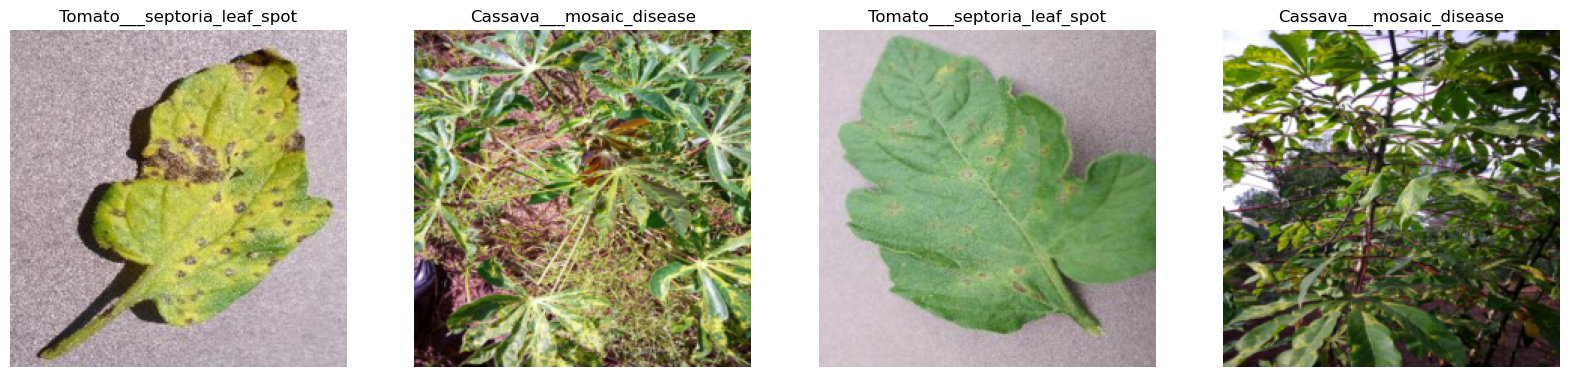

In [23]:
# display 4 images picked at random in the dataset and their label 
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    idx = np.random.randint(len(dataset))
    img, label = dataset[idx]
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].set_title(dataset.class_names[label])
    axs[i].axis('off')
plt.show()

## Class distribution of the dataset

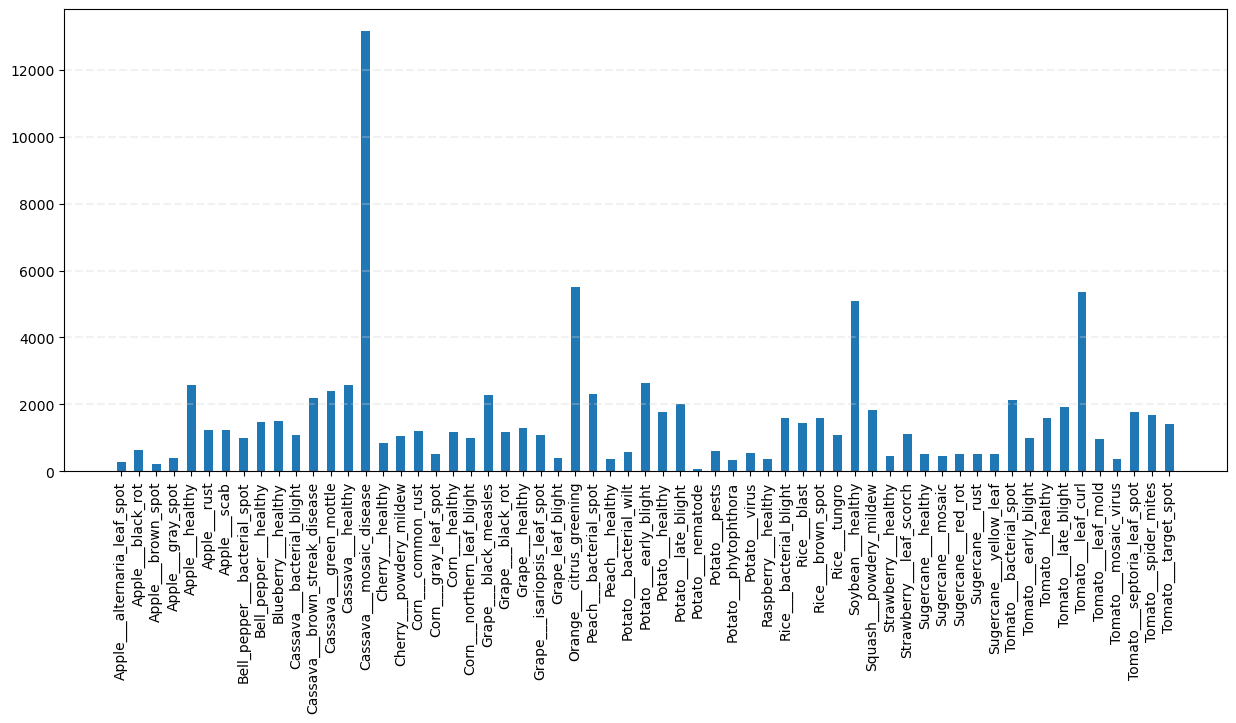

In [24]:
def plot_distribution(dataset):
    count = np.zeros(len(dataset.class_names))
    for _, label in dataset:
        count[label] += 1
    plt.figure(figsize=(15, 6))  # Set the figure size
    plt.bar(dataset.class_names, count, width=0.5)  # Adjust the width of the bars
    plt.xticks(rotation=90)  # Rotate the x-axis labels
    
    # Add light gray dashed lines horizontally
    for i in np.arange(2000, 12001, 2000):
        plt.axhline(i, color='lightgray', linestyle='dashed', alpha=0.3)
    
    plt.show()

plot_distribution(dataset)

## Average & standard deviation of the images

In [25]:
def get_mean_std(dataset, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for batch_images, _ in dataloader:
        mean += batch_images.mean(dim=(0, 2, 3))
        std += batch_images.std(dim=(0, 2, 3))
    mean /= len(dataloader)
    std /= len(dataloader)
    return mean, std

mean, std = get_mean_std(dataset, batch_size=256)
print('mean: ', mean)
print('std: ', std)

mean:  tensor([0.4557, 0.4969, 0.3778])
std:  tensor([0.1991, 0.1820, 0.2096])
